In [1]:
import glob
import json
import pandas as pd
import scipy.stats as stats
from src.helper import *
%matplotlib inline

In [2]:
from plotly.offline import iplot, init_notebook_mode
from plotly.plotly import iplot as iplot_ol
import plotly.graph_objs as go
init_notebook_mode(True)

In [3]:
# load data
prjs_url = pd.read_csv('data/projects_url.csv')
prjs_loc = pd.read_csv('data/projects_location.csv')
prjs_info = pd.read_csv('data/projects_features.csv')
prjs_woeid = pd.read_csv('data/projects_woeid.csv')
prjs_backer_cities = pd.concat([pd.read_csv(fn)for fn in glob.glob('data/scraped/patch-woeid/projs*cities*.csv')])
prjs_backer_countries = pd.concat([pd.read_csv(fn)for fn in glob.glob('data/scraped/patch-woeid/projs*countries*.csv')])

In [4]:
# clean data

## successful as positive = 1
print prjs_info.state.value_counts().to_dict()
prjs_info['state_as_int'] = prjs_info.state.apply(lambda x: 1 if x=='successful' else 0)

## get int of cnt
prjs_backer_cities.cnt = prjs_backer_cities.cnt.apply(get_int)
prjs_backer_countries.cnt = prjs_backer_countries.cnt.apply(get_int)

{'successful': 60672, 'failed': 61919}


# questions in [here](https://docs.google.com/document/d/1jtUO96uMZyXAYjd7m88q7vTKaWF7kyNPyN1eyaK0W2M/edit)

## Question 1

### data

In [ ]:
prjs_wise_src2des = prjs_woeid.merge(prjs_backer_cities)
same_src_des = prjs_wise_src2des[prjs_wise_src2des.proj_woeid==prjs_wise_src2des.woeid]
# make sure one line is one project
assert same_src_des.id.nunique() == same_src_des.shape[0]
# add proj information
same_src_des = prjs_info[['id', 'category_parent', '#backer', 'state']].merge(same_src_des, how='left')
# those projects with nan means their cities are not shown in top 10 backers cities
same_src_des.fillna(0, inplace=True)
same_src_des['same_city_pcnt'] = same_src_des.apply(lambda x: x.cnt*1.0/x['#backer'] if x['#backer']!=0 else 0, axis=1)

In [ ]:
same_src_des_backers_cnt = same_src_des[['state', 'cnt']].groupby('state').cnt.apply(list).to_dict()
same_src_des_backers_pcnt = same_src_des[['state', 'same_city_pcnt']].groupby('state').same_city_pcnt.apply(list).to_dict()
save_dict_of_list(same_src_des_backers_cnt, 'data/ana/same_src_des_backer_cnt.txt')
save_dict_of_list(same_src_des_backers_pcnt, 'data/ana/same_src_des_backer_pcnt.txt')

### statistical tests 

In [ ]:

print 'number of backers'
print stats.f_oneway(same_src_des_backers_cnt['failed'], same_src_des_backers_cnt['successful'])
print stats.kruskal(same_src_des_backers_cnt['failed'], same_src_des_backers_cnt['successful'])

print 

print 'percentage of bakcers'
print stats.f_oneway(same_src_des_backers_pcnt['failed'], same_src_des_backers_pcnt['successful'])
print stats.kruskal(same_src_des_backers_pcnt['failed'], same_src_des_backers_pcnt['successful'])

### plot

In [ ]:
l = same_src_des_backers_cnt
title = 'number of backers from the same city of the project'
data = [go.Box(y=l['failed'], name='failed'), go.Box(y=l['successful'], name='successful'),]
layout = go.Layout(title=title)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
l = same_src_des_backers_pcnt
title = 'percentage of backers from the same city of the project'
data = [go.Box(y=l['failed'], name='failed'), go.Box(y=l['successful'], name='successful'),]
layout = go.Layout(title=title)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Question 2: Entropy

### data

In [5]:
def get_ent(edges, des_or_cate='des'):
    data = edges.groupby([des_or_cate,'src']).agg({'src_backers': 'sum'}).reset_index()
    data = data.pivot(index=des_or_cate, columns='src', values='src_backers')
    print data.shape
    data.fillna(0,inplace=True)
    ent = data.apply(stats.entropy, axis=1)
    return ent

### entropy by des

(361, 16445)


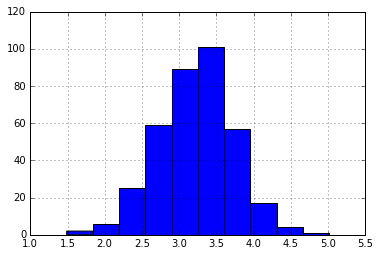

In [6]:
edges = pd.read_csv('data/pledge_network_edges_thres_10.csv', index_col=0)
ent = get_ent(edges)
ent.hist()

(7647, 21270)


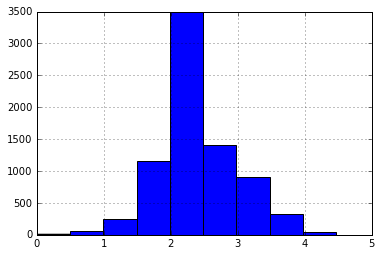

In [7]:
edges = pd.read_csv('data/pledge_network_edges.csv', index_col=0)
ent = get_ent(edges)
ent.hist()

### entropy by category

(14, 16445)


category
design          3.528200
games           3.644239
comics          3.706140
technology      3.806180
dance           3.832950
theater         4.043077
photography     4.395215
fashion         4.615022
film & video    4.704090
crafts          4.897414
publishing      4.962422
art             5.020326
food            5.066709
music           5.757100
dtype: float64

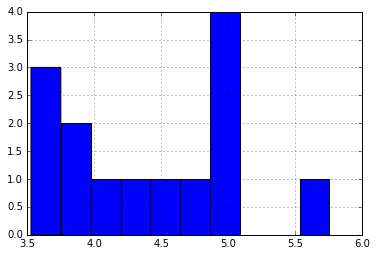

In [16]:
edges = pd.read_csv('data/pledge_network_edges_thres_10.csv', index_col=0)
ent = get_ent(edges,'category')
ent.hist()
ent.sort_values()

(15, 21270)


category
journalism      3.344604
design          3.825913
games           3.881975
technology      4.087933
comics          4.299503
dance           4.911569
film & video    5.050539
fashion         5.071588
photography     5.125155
theater         5.171596
publishing      5.371441
art             5.476277
crafts          5.725965
food            5.858305
music           6.047867
dtype: float64

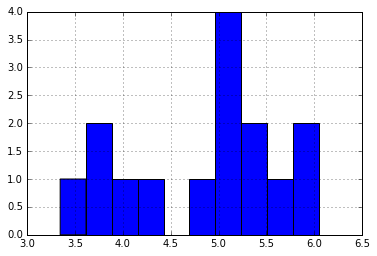

In [15]:
edges = pd.read_csv('data/pledge_network_edges.csv', index_col=0)
ent = get_ent(edges, 'category')
ent.hist()
ent.sort_values()